In [1]:
from astropy.io import fits
from astropy import wcs, units
import numpy as np
import pylab as plt 
from spectral_cube import SpectralCube
from astropy.coordinates import SkyCoord
import aplpy
import time
%matplotlib inline


In [3]:
cand  = np.loadtxt('/home/themba/Documents/MSc/Thesis/catalogue/ppmos1/ghs.txt') #Loads text file with candidates 
X,Y,Z = cand[:,1], cand[:,2], cand[:,3]                                                 #coordinates.
size  = cand.shape[0]


hdu = fits.open('../Data/ppmos1/wsrt/ppmosALL_1_kms.fits')
Header = hdu[0].header
cube = hdu[0].data
#data = hdu[0].data
#voxel_units =  h['BUNIT'], vel_units = h['CUNIT3']
std = 0.4*1e-3 #from mpati's paper [Jy]
dv = Header['CDELT3']   #channel width [km/s]

#dir = '/home/themba/Documents/MSC/Thesis/catalogue/ppmos3/Update/' #directory to save data products.
dir = '/media/themba/c18d84e6-53eb-44c6-be34-18234c64ea16/MSc/ppmos1/global_profiles/'

In [4]:
#In this code cell I extract subcubes that contain galaxy candidates.
#I also plot moment zero maps and pv slices of each candidate

#boundaries of the cube 
zzl,yyl,xxl = 0.,0.,0.0
zzu,yyu,xxu = cube.shape 
s,v     = 50,50          # s= spacial width & v = velocity width of the cubelet.

def Mome0(cube):       #This function creates masked subcubes and moment zero maps.
    nz,ny,nx=cube.shape
    cube1 = np.zeros((nz,ny,nx))
    
    for i in range(nz):
        for j in range(ny):
            for k in range(nx):
                a = cube[i,j,k]
                if a >= 3.*std:
                    cube1[i,j,k]=cube1[i,j,k]+cube[i,j,k]
                    #print cube[i,j,k]
                else:
                    cube1[i,j,k]=cube1[i,j,k]+0.0
       
    mom0 = np.zeros((ny,nx))
    for i in range(nz):
        #mom0 = mom0+cube1[i,:,:] #masked moment map (<3*std)
        mom0 = mom0+cube[i,:,:]  #un-masked moment map
    return mom0 ,cube1


def cublets(z,y,x,k):            #This function extracts subcubes from the origion dataset.
    ##cublet boundaries    
    Xl,Xu,Yl,Yu,Zl,Zu=0,0,0,0,0,0
    #X-axis boundaries
    ss=0
    Sxu,Sxl = x+s, x - s #sub_cube upper & lower bounds, respectively
    Syu,Syl = y+s, y - s
    Szu,Szl = z+v, z - v
    
    
    if (Syu <= yyu and Syl >= yyl and Sxu <= xxu and Sxl >= xxl):  # This is for a subcube that is contain within the cube
        Yu  = Syu
        Yl  = Syl
        Xu  = Sxu
        Xl  = Sxl
    
    
    
    else:
    
        if Sxu > xxu:
            Sxu = xxu - x #half width
            Xu  = x+Sxu
            Xl  = x-Sxu
            
            Yu  = y + Sxu
            Yl  = y - Sxu
        if Sxl < xxl:
            Sxl = x-xxl
            Xu  = x+Sxl
            Xl  = x-Sxl
            
            Yu  = y + Sxl
            Yl  = y - Sxl

        #Y-axis boundaries
        if Syu > yyu:
            Syu = yyu - y
            Yu  = y+Syu
            Yl  = y-Syu
            
            Xu  = x + Syu
            Xl  = x - Syu
            
        if Syl < yyl:
            Syl = y-yyl
            Yu  = y+Syl
            Yl  = y-Syl

            Xu  = x + Syl
            Xl  = x - Syl        
        
        #Z-axis boundaries
        if Szu > zzu:    
            Szu = zzu - z    
            Zu  = z+Szu    
            Zl  = z-Szu    
        if Szl < zzl:    
            Szl = z-zzl    
            Zu  = z+Szl    
            Zl  = z-Szl    
            
        if (Szu <= zzu and Szl >= zzl):    
            Zu = Szu    
            Zl = Szl    
    
    

    sub_cube1 = cube[Szl:Szu,Yl:Yu,Xl:Xu] #cublet

    
    #PV slices
    sub_cube = Mome0(sub_cube1)[1] #masked sub_cube, comment this out to get un-masked pv-slices
    nz,ny,nx = sub_cube.shape
    
    ZY = np.zeros((nz,ny))
    XZ = np.zeros((nz,nx))
    
    
    for i in range(nx):
        ZY = ZY+sub_cube[:,:,i]
    
    for i in range(ny):
        XZ = XZ + sub_cube[:,i,:]
    
    mom0 = Mome0(sub_cube)[0]
    plt.subplot(131)
    plt.imshow(mom0)
    plt.title('Mom0')
    plt.gca().invert_yaxis()
    
    
    plt.subplot(132)
    plt.imshow(ZY)
    plt.title('ZY Slice')
    plt.gca().invert_yaxis()
    
    plt.subplot(133)
    plt.imshow(XZ)
    plt.title('XZ Slice')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    #fits.writeto(dir+'mom0_'+str(k)+'.fits',Mome0(sub_cube)[0],clobber=True)
    #fits.writeto(dir+'msk_cube_'+str(k)+'.fits',Mome0(sub_cube)[1],clobber=True)
    if k < 10:
        #fits.writeto(dir+'mom0_T20'+str(k)+'.fits',Mome0(sub_cube)[0],clobber=True)
        #fits.writeto(dir+'msk_T20'+str(k)+'.fits',Mome0(sub_cube)[1],clobber=True)
        fits.writeto(dir+'C20'+str(k)+'.fits',sub_cube1,clobber=True) #unmasked
        plt.savefig (dir+'C20'+str(k)+'.png')
    else:
        #fits.writeto(dir+'mom0_T2'+str(k)+'.fits',Mome0(sub_cube)[0],clobber=True)
        #fits.writeto(dir+'msk_T2'+str(k)+'.fits',Mome0(sub_cube)[1],clobber=True)
        fits.writeto(dir+'C2'+str(k)+'.fits',sub_cube1,clobber=True) #unmasked
        plt.savefig (dir+'C2'+str(k)+'.png')    



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:98: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


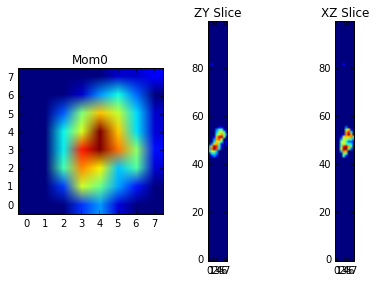

In [9]:
for i in range(size): #creating subcubes
    cublets(Z[i],Y[i],X[i],i)

In [10]:
#n this code cell I update the headers of the subcubes and moment zero fits files.

#header.update({'NAXIS1': 100, 'NAXIS2': 100})
Header.set('ctype3', 'velo')
w= wcs.WCS(Header)

CDELT1 = Header.get('CDELT1')
CTYPE1 = Header.get('CTYPE1')
CROTA1 = Header.get('CROTA1')
CUNIT1 = Header.get('CUNIT1')
 
CDELT2 = Header.get('CDELT2')
CTYPE2 = Header.get('CTYPE2')
CROTA2 = Header.get('CROTA2')
CUNIT2 = Header.get('CUNIT2') 

CDELT3 = Header.get('CDELT3')
CTYPE3 = Header.get('CTYPE3')
CROTA3 = Header.get('CROTA3')
CUNIT3 = Header.get('CUNIT3')

BUNIT  = Header.get('BUNIT')
BLANK  = Header.get('BLANK')
EPOCH  = Header.get('EPOCH')
FREQ0  = Header.get('FREQ0')

def headr(cube,x,y,z,t):
    #naxis3,naxis2,naxis1 = cube.shape
    crval1,crval2,crval3 = w.all_pix2world(x,y,z,0)
    hdu    = fits.open(cube)
    header = hdu[0].header
    data   = hdu[0].data
    dim = data.shape
    if t==0:
        xx,yy = data.shape
    elif t==1:
        zz,yy,xx = data.shape
    
    header.insert('EXTEND ', ('CDELT1', CDELT1), after=True)
    header.insert('CDELT1 ', ('CROTA1', CROTA1), after=True)
    header.insert('CROTA1 ', ('CRPIX1', 0.5*xx), after=True)
    header.insert('CRPIX1 ', ('CRVAL1', crval1[()]), after=True)
    header.insert('CRVAL1 ', ('CTYPE1', CTYPE1), after=True)
    header.insert('CTYPE1 ', ('CUNIT1', CUNIT1), after=True)
    
    header.insert('CUNIT1 ', ('CDELT2', CDELT2), after=True)
    header.insert('CDELT2 ', ('CROTA2', CROTA2), after=True)
    header.insert('CROTA2 ', ('CRPIX2', 0.5*yy), after=True)
    header.insert('CRPIX2 ', ('CRVAL2', crval2[()]), after=True)
    header.insert('CRVAL2 ', ('CTYPE2', CTYPE2), after=True)
    header.insert('CTYPE2 ', ('CUNIT2', CUNIT2), after=True)    
    
    if t==1:
        header.insert('CUNIT2 ', ('CDELT3', CDELT3), after=True)
        header.insert('CDELT3 ', ('CROTA3', CROTA3), after=True)
        header.insert('CROTA3 ', ('CRPIX3', 0.5*zz), after=True)
        header.insert('CRPIX3 ', ('CRVAL3', crval3[()]), after=True)
        header.insert('CRVAL3 ', ('CTYPE3', CTYPE3), after=True)
        header.insert('CTYPE3 ', ('CUNIT3', CUNIT3), after=True)
           
        header.insert('CUNIT3 ', ('BLANK', BLANK), after=True)
        header.insert('BLANK ', ('BUNIT', BUNIT), after=True) 
        header.insert('BUNIT ', ('EPOCH', EPOCH), after=True)
        header.insert('EPOCH ', ('FREQ0', FREQ0), after=True)
        fits.writeto(filename=cube,data=data,header=header,clobber=True) 
    elif t==0:
        header.insert('CUNIT2 ', ('BUNIT', 'Jy km/s'), after=True)
        header.insert('BUNIT ', ('EPOCH', EPOCH), after=True)
        header.insert('EPOCH ', ('FREQ0', FREQ0), after=True)
        fits.writeto(filename=cube,data=data,header=header,clobber=True)
            

In [11]:
#Updatigng headers
for k in range(size):
    if k <10:
        headr(dir+'C20'+str(k)+'.fits',X[k],Y[k],Z[k],1) #cube header
        #headr(dir+'msk_T20'+str(k)+'.fits',X[k],Y[k],Z[k],1) #cube header
        #headr(dir+'mom0_T20'+str(k)+'.fits',X[k],Y[k],Z[k],0)       #mom0 header
    else:
        headr(dir+'C2'+str(k)+'.fits',X[k],Y[k],Z[k],1) #cube header
        #headr(dir+'msk_T2'+str(k)+'.fits',X[k],Y[k],Z[k],1) #cube header
        #headr(dir+'mom0_T2'+str(k)+'.fits',X[k],Y[k],Z[k],0)       #mom0 header  


In [12]:
def hms(f):
    H = f/15.
    h = int(H)
    m = int((H-h)*60)
    s =round((((H-h)*60 - m)*60),2)
    return h,m,s
    
def dms(f):
    d = int(f)
    m = int((f - d)*60.)
    s = round(((f - d)*60. - m)*60,1)
    return d, m,s
    

In [13]:
#pixels to world

def p2w(x,y,z):
    crval1,crval2,crval3 = w.all_pix2world(x,y,z,0)
    ra = crval1*units.deg
    dec = crval2*units.deg
    c = SkyCoord(ra=ra,dec=dec)
    u = c.galactic
    print hms(crval1),'   ', dms(crval2),'   ',round(crval3,0),'   ',u

for i in range (size):
    p2w(X[i],Y[i],Z[i])

(4, 52, 4.15)     (45, 48, 43.0)     11130.0     <SkyCoord (Galactic): (l, b) in deg
    (160.13860258, 1.04736978)>
(4, 52, 6.21)     (45, 54, 19.2)     10553.0     <SkyCoord (Galactic): (l, b) in deg
    (160.07028576, 1.11133176)>
(4, 52, 31.6)     (46, 25, 9.2)     8187.0     <SkyCoord (Galactic): (l, b) in deg
    (159.7196394, 1.49417692)>
(4, 54, 43.69)     (45, 47, 48.3)     10735.0     <SkyCoord (Galactic): (l, b) in deg
    (160.44345763, 1.39674828)>
(4, 55, 21.29)     (46, 40, 12.1)     8410.0     <SkyCoord (Galactic): (l, b) in deg
    (159.83184954, 2.02970932)>
(4, 55, 27.37)     (45, 52, 23.4)     12606.0     <SkyCoord (Galactic): (l, b) in deg
    (160.46369824, 1.54342511)>
(4, 55, 29.23)     (46, 29, 17.6)     9069.0     <SkyCoord (Galactic): (l, b) in deg
    (159.98780317, 1.93340906)>
(4, 55, 40.16)     (46, 49, 29.7)     9589.0     <SkyCoord (Galactic): (l, b) in deg
    (159.74490607, 2.16877702)>
(4, 55, 45.15)     (45, 51, 10.7)     15360.0     <SkyCoord (Gala

In [ ]:
gal = np.loadtxt(dir+'galactic.txt')
j   = gal.shape[0]
for k in range(j):
    print round(gal[k,0],2),'   ',round(gal[k,1],2)
#gal[:,0]

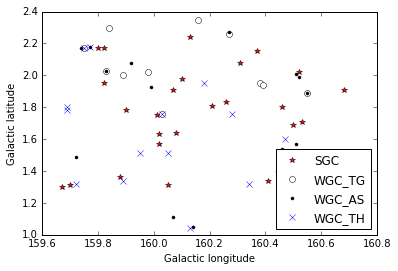

In [16]:
# Review and fix the columns of the ff data files: themba.txt, anja.txt & trish.txt

dir2 = '/home/themba/Documents/MSC/Thesis/catalogue/ppmos2/'
trish  = np.loadtxt(dir2+'Trish/'+'trish.txt')
themba = np.loadtxt(dir2+'themba/'+'themba.txt')
anja   = np.loadtxt(dir2+'Anja/'+'anja.txt')
GHS    = np.loadtxt(dir2+'GHS.txt')
plt.plot(GHS[:,4],GHS[:,5],'r*',label='SGC')
plt.plot(themba[:,4],themba[:,5],'wo',label='WGC_TG')
plt.plot(anja[:,4],anja[:,5],'k.',label='WGC_AS')
plt.plot(trish[:,4],trish[:,5],'bx',label='WGC_TH')
plt.xlabel('Galactic longitude')
plt.ylabel("Galactic latitude")
plt.legend(loc=4,numpoints=1)
plt.savefig(dir2+'GHS.pdf')



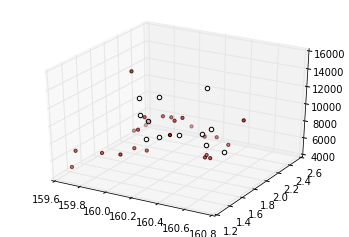

In [30]:
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter3D(GHS[:,4],GHS[:,5],GHS[:,6], s=10, c=u'r', depthshade=True)
ax.scatter3D(themba[:,4],themba[:,5],themba[:,6], s=20, c=u'w', depthshade=False)

In [27]:
ax.scatter3D?
